In [29]:
import json

a_no_to_symbol = {1:"H", 2:"He", 3:"Li", 4:"Be", 5:"B", 6:"C", 7:"N", 8:"O", 9:"F", 10:"Ne",
    11:"Na", 12:"Mg", 13:"Al", 14:"Si", 15:"P", 16:"S", 17:"Cl", 18:"Ar", 19:"K", 20:"Ca",
    21:"Sc", 22:"Ti", 23:"V", 24:"Cr", 25:"Mn", 26:"Fe", 27:"Co", 28:"Ni", 29:"Cu", 30:"Zn",
    31:"Ga", 32:"Ge", 33:"As", 34:"Se", 35:"Br", 36:"Kr", 37:"Rb", 38:"Sr", 39:"Y", 40:"Zr",
    41:"Nb", 42:"Mo", 43:"Tc", 44:"Ru", 45:"Rh", 46:"Pd", 47:"Ag", 48:"Cd", 49:"In", 50:"Sn",
    51:"Sb", 52:"Te", 53:"I", 54:"Xe", 55:"Cs", 56:"Ba", 57:"La", 58:"Ce", 59:"Pr", 60:"Nd",
    61:"Pm", 62:"Sm", 63:"Eu", 64:"Gd", 65:"Tb", 66:"Dy", 67:"Ho", 68:"Er", 69:"Tm", 70:"Yb",
    71:"Lu", 72:"Hf", 73:"Ta", 74:"W", 75:"Re", 76:"Os", 77:"Ir", 78:"Pt", 79:"Au", 80:"Hg",
    81:"Tl", 82:"Pb", 83:"Bi", 84:"Po", 85:"At", 86:"Rn", 87:"Fr", 88:"Ra", 89:"Ac", 90:"Th",
    91:"Pa", 92:"U", 93:"Np", 94:"Pu", 95:"Am", 96:"Cm", 97:"Bk", 98:"Cf", 99:"Es", 100:"Fm",
    101:"Md", 102:"No", 103:"Lr", 104:"Rf", 105:"Db", 106:"Sg", 107:"Bh", 108:"Hs", 109:"Mt", 110:"Ds",
    111:"Rg"}

symbol_to_a_no = {}
for a_no in a_no_to_symbol:
    symbol_to_a_no[a_no_to_symbol[a_no]] = a_no


def cart(x,y):
    return ((x[0]-y[0])**2 + (x[1]-y[1])**2 + (x[2]-y[2])**2)**0.5
    
class Atom:
    def __init__(self, coord, a_no):
        self.coord = coord
        self.a_no = a_no   
        
class Fragment:
    def __init__(self, atoms = []):
        self.atoms = []
        self.charge = 0
        self.weighted_centre = [0.0,0.0,0.0]
        for atom in atoms:
            self.add_atom(atom)
            
    def add_atom(self, atom):
        self.atoms.append(atom)
        self.charge += atom.a_no
        for i in range(3):
            self.weighted_centre[i] += atom.coord[i]*atom.a_no
            
    def centre_of_charge(self):
        return [self.weighted_centre[i]/self.charge for i in range(3)]
    
    def locality(self):
        centre = self.centre_of_charge()
        dist = 0.0
        for atom in self.atoms:
            dist += cart(atom.coord,centre)**2
        dist /= len(self.atoms)
        return dist
    
    def fingerprint(self):
        elements = {}
        for atom in self.atoms:
            symbol = a_no_to_symbol[atom.a_no]
            if symbol not in elements:
                elements[symbol] = 0
            elements[symbol] += 1
            
        el_list = list(elements.items())
        el_list.sort(key=lambda x:x[0])
        
        
        ret = ""
        for el in el_list:
            ret += el[0]
            ret += str(el[1])
        return ret
            
def union(fragments):
    new_frag = Fragment([])
    for frag in fragments:
        new_frag.atoms.extend(frag.atoms)
        new_frag.charge += frag.charge
        for i in range(3):
            new_frag.weighted_centre[i] += frag.weighted_centre[i]
    return new_frag


# Represents topology component of input json
class Topology:
    def __init__(self):
        self.atoms = []
        self.connectivity = []
        self.fragments = []
        self.fragment_formal_charges = []
        
    def assemble_fragments(self):
        ret = []
        for atom_ixs in self.fragments:
            ret.append(Fragment([self.atoms[i] for i in atom_ixs]))
        return ret
        
    def from_json(self, topology_json, connected_fragments = False):
        
        symbols = topology_json['symbols']
        raw_coords = topology_json['geometry']
        
        coords = []
        for i in range(0, len(raw_coords), 3):
            coords.append([raw_coords[i],raw_coords[i+1],raw_coords[i+2]])

        for (symbol, coord) in zip(symbols,coords):
            self.atoms.append(Atom(coord, symbol_to_a_no[symbol]))
            
        nfrag = len(topology_json['fragments'])
            
        
        self.connectivity = topology_json['connectivity']
        if connected_fragments:
            self.fragment_by_connectivity()
            self.fragment_formal_charges = [0 for _ in range(len(self.fragments))]
            print("FORMAL CHARGES DON'T WORK WITH CONNECTED FRAGMENTATION")
        else:
            self.fragments = topology_json['fragments']
            self.fragment_formal_charges = topology_json["fragment_formal_charges"]
        
    def fragment_by_connectivity(self):
        
        reps = [i for i in range(len(self.atoms))]
        for (i,j,_) in self.connectivity:
            x = 0
            y = 0
            if reps[i] < reps[j]:
                x,y = i,j
            else:
                x,y = j,i
            component = []
            to_change = reps[y]
            for k in range(len(reps)):
                if reps[k] == to_change:
                    reps[k] = reps[x]
                if reps[k] == reps[x]:
                    component.append(k)
                    
        i = 0
        frags = [[] for _ in set(reps)]
        for rep in set(reps):
            for j in range(len(self.atoms)):
                if reps[j] == rep:
                    frags[i].append(j)
            i += 1
        self.fragments = frags
        
    def to_json(self):
        topology_json = {}
        topology_json['fragments'] = self.fragments
        topology_json['fragment_formal_charges'] = self.fragment_formal_charges
        topology_json['connectivity'] = self.connectivity
        
        topology_json['geometry'] = []
        topology_json['symbols'] = []
        for atom in self.atoms:
            topology_json['symbols'].append(a_no_to_symbol[atom.a_no])
            topology_json['geometry'].extend(atom.coord)
        return topology_json

    def nfrag(self):
        return len(self.fragments)
    
    def natoms(self):
        return len(self.atoms)
    
    def group_fragments(self, group_map):
        assert(len(group_map) == len(self.fragments))
        ret = Topology()
        ret.atoms = self.atoms
        ret.connectivity = self.connectivity
        
        nfrag = max(group_map)+1
        ret.fragments = [[] for _ in range(nfrag)]
        ret.fragment_formal_charges = [0 for _ in range(nfrag)]
        for old_frag_ix, new_frag_ix in enumerate(group_map):
            ret.fragments[new_frag_ix].extend(self.fragments[old_frag_ix])
            ret.fragment_formal_charges[new_frag_ix] += self.fragment_formal_charges[old_frag_ix]
        return ret


def check_for_pairs(frags):
    fingerprints = {}
    for frag in frags:
        prnt = frag.fingerprint()
        if prnt not in fingerprints:
            fingerprints[prnt] = 0
        fingerprints[prnt] += 1
    
    if len(set(fingerprints.keys())) == 2 and len(set(fingerprints.values())) == 1 :
        return list(fingerprints.keys())
    else:
        return None

In [34]:
input_file = None
with open("gdmbf4_48_1frag.json") as f:
    input_file = json.load(f)
# with open("cip48.json") as f:
#     input_file = json.load(f)

topology = Topology()
topology.from_json(input_file, connected_fragments=True)

if check_for_pairs(topology.assemble_fragments()):
    print("Pairs detected")

FORMAL CHARGES DON'T WORK WITH CONNECTED FRAGMENTATION
Pairs detected


In [35]:
from sklearn.cluster import KMeans
import numpy as np

def pair_fragments(frags, fragsA_map, fragsB_map):    
    membership = []
    fragsA = [frags[ix] for ix in fragsA_map]
    fragsB = [frags[ix] for ix in fragsB_map]
    for i in range(len(fragsB)):
        membership.append(i)
            
    def gain(i,j):
        ci = fragsA[membership[i]].centre_of_charge()
        cj = fragsA[membership[j]].centre_of_charge()
        current = cart(fragsB[i].centre_of_charge(),ci) + cart(fragsB[j].centre_of_charge(),cj)
        swapped = cart(fragsB[j].centre_of_charge(),ci) + cart(fragsB[i].centre_of_charge(),cj)
        return current - swapped
    
    prev_mem = []
    for i in range(10):
        if i > 0:
            done = True
            for x,y in zip(membership, prev_mem):
                if x != y:
                    done = False
                    break
            if done:
                print("CONVERGED!")
                break
        prev_mem = membership.copy()
        print("Iteration",i)

        deltas = []
        for i,frag in enumerate(fragsB):
            mem = membership[i]
            clust = -1
            best_alternative = 1000000.0
            for j,centroid in [(j,fragsA[j].centre_of_charge()) for j in range(len(fragsA)) if j != mem]:
                dist = cart(frag.centre_of_charge(),centroid)
                if dist < best_alternative:
                    best_alternative = dist
                    clust = j
            deltas.append((i,best_alternative-cart(frag.centre_of_charge(),fragsA[mem].centre_of_charge()),clust))

        deltas = sorted(deltas, key=lambda x: x[1])

        for (i,delta,best) in deltas:
            for (j,fragj) in enumerate(fragsA):
                if membership[i] == j:
                    continue
                done = False
                if gain(i,j) > 0:
                    membership[i], membership[j] = membership[j], membership[i]
                    done = True
                if done:
                    break
    
    ret = []
    for i in range(len(frags)):
        if i in fragsA_map:
            for j in range(len(fragsA_map)):
                if fragsA_map[j] == i:
                    ret.append(j)
                    break
        else:
            for j in range(len(fragsB_map)):
                if fragsB_map[j] == i:
                    ret.append(membership[j])
                    break
    return ret


def cluster_fragments(frags, multiplicity):
    print("Clustering")
    centres = np.array([frag.centre_of_charge() for frag in frags])
    weights = np.array([frag.charge for frag in frags])
    
    clusters = len(frags)//multiplicity
    print(clusters)
    kmeans = KMeans(n_clusters=clusters, random_state=0).fit(centres, sample_weight=weights)
    
    print("Equalizing")
    
    return equalize_clusters(frags, kmeans.labels_, kmeans.cluster_centers_)

def equalize_clusters(frags, membership, centroids):
    # make clusters equal sizes
    def gain(i,j):
        ci = centroids[membership[i]]
        cj = centroids[membership[j]]
        current = cart(frags[i].centre_of_charge(),ci) + cart(frags[j].centre_of_charge(),cj)
        swapped = cart(frags[j].centre_of_charge(),ci) + cart(frags[i].centre_of_charge(),cj)
        return current - swapped
    
    def fragsize(i):
        return sum([1 if mem == i else 0 for mem in membership])
    
    prev_mem = []
    for i in range(10):
        
        if i > 0:
            done = True
            for x,y in zip(membership, prev_mem):
                if x != y:
                    done = False
                    break
            if done:
                print("CONVERGED!")
                break
        prev_mem = membership.copy()
        print("Iteration",i)
        # Calculate centroids
        #print("ITER")
        for i in range(len(centroids)):
            cent = [0.0,0.0,0.0]
            n = 0
            for (j,mem) in enumerate(membership):
                if mem == i:
                    cent[0] += frags[j].centre_of_charge()[0]*frags[j].charge
                    cent[1] += frags[j].centre_of_charge()[1]*frags[j].charge
                    cent[2] += frags[j].centre_of_charge()[2]*frags[j].charge
                    n += frags[j].charge
            if n > 0:
                cent[0] /= n
                cent[1] /= n
                cent[2] /= n
            centroids[i] = cent
        
        outgoing = {}
        for i in range(len(centroids)):
            outgoing[i] = []


        deltas = []
        for i,frag in enumerate(frags):
            mem = membership[i]
            clust = -1
            best_alternative = 1000000.0
            for j,centroid in [(j,centroids[j]) for j in range(len(centroids)) if j != mem]:
                dist = cart(frag.centre_of_charge(),centroid)
                if dist < best_alternative:
                    best_alternative = dist
                    clust = j
            deltas.append((i,best_alternative-cart(frag.centre_of_charge(),centroids[membership[i]]),clust))

        deltas = sorted(deltas, key=lambda x: x[1])
        for (i,delta,best) in deltas:
            for (j,centroid) in enumerate(centroids):
                if membership[i] == j:
                    continue

                done = False
                for k in range(len(outgoing[j])):
                    if gain(i,outgoing[j][k]) > 0:
                        swap = outgoing[j].pop(k)
                        #print("Swap", i, "with", swap, "for gain")
                        membership[i], membership[swap] = membership[swap], membership[i]
                        done = True
                        break
                if done:
                    break

                if fragsize(j) < len(frags)//len(centroids) < fragsize(membership[i]):
                    #print("Move frag", i, "to cluster", j, "for size")
                    membership[i] = j
                    break
                    
                outgoing[membership[i]].append(i)

    return membership

    

In [55]:
fragments = topology.assemble_fragments()
processed_fragments = fragments
processed_topology = topology

pair_fingerprints = check_for_pairs(fragments)
if pair_fingerprints:
    print("PAIRED INPUT")
    fragsA = []
    fragsB = []
    for (i,frag) in enumerate(fragments):
        if frag.fingerprint() == pair_fingerprints[0]:
            fragsA.append(i)
        else:
            fragsB.append(i)
        
    paired_fragments_map = pair_fragments(fragments,fragsA,fragsB)
    paired_topology = topology.group_fragments(paired_fragments_map)
    paired_fragments = paired_topology.assemble_fragments()
    
    processed_fragments = paired_fragments
    processed_topology = paired_topology

enlarged_fragments_map = cluster_fragments(processed_fragments,3)
enlarged_topology = processed_topology.group_fragments(enlarged_fragments_map)
enlarged_fragments = enlarged_topology.assemble_fragments()
# enlarged_fragments = cluster_fragments(fragments,30)
# enlarged_fragments = processed_fragments
# enlarged_topology = processed_topology

# print("Old fragment locality:")
# print("Worst:",max([frag.locality() for frag in fragments]))
# print("Best: ",min([frag.locality() for frag in fragments]))


print("New fragment locality:")
# print("Worst:",max([frag.locality() for frag in enlarged_fragments]))
# print("Best: ",min([frag.locality() for frag in enlarged_fragments]))


PAIRED INPUT
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
CONVERGED!
Clustering
16
Equalizing
Iteration 0
Iteration 1
Iteration 2
CONVERGED!
New fragment locality:


<IPython.core.display.Javascript object>


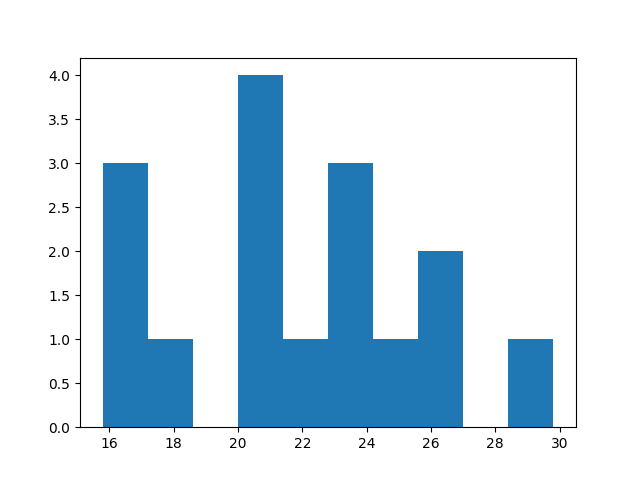

Max at frag 13


(array([3., 1., 0., 4., 1., 3., 1., 2., 0., 1.]),
 array([15.78920703, 17.19141895, 18.59363086, 19.99584278, 21.39805469,
        22.80026661, 24.20247852, 25.60469044, 27.00690235, 28.40911427,
        29.81132618]),
 <BarContainer object of 10 artists>)

In [56]:
fig = plt.figure()
ax = fig.add_subplot()

localities = [frag.locality() for frag in enlarged_fragments]
for i in range(len(localities)):
    if localities[i] == max(localities):
        print("Max at frag", i)

ax.hist(localities)

In [37]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

def plot_fragments(frags, highlight = -1):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    for (i,frag) in enumerate(frags):
        xs = [atom.coord[0] for atom in frag.atoms]
        ys = [atom.coord[1] for atom in frag.atoms]
        zs = [atom.coord[2] for atom in frag.atoms]
        
        c = None
        if highlight >= 0:
            c = '#1f77b4' if i != highlight else '#ff7f0e'
        ax.scatter(xs,ys,zs,c=c)
        
fragment_index = 0

8


<IPython.core.display.Javascript object>


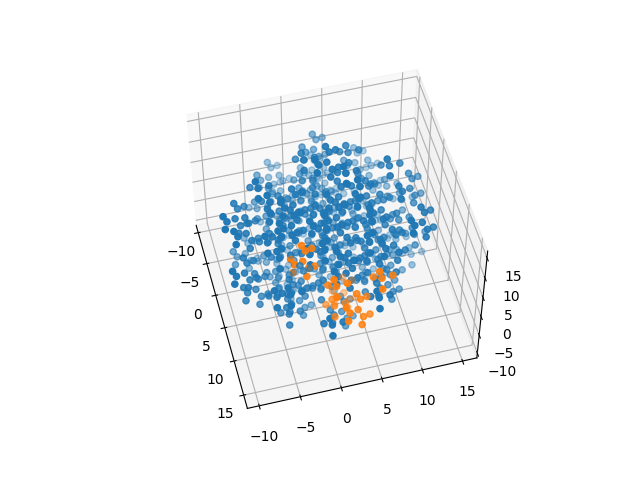

In [57]:
print(fragment_index)
#plot_fragments(paired_fragments,fragment_index)
plot_fragments(enlarged_fragments,13)

fragment_index += 1

1


<IPython.core.display.Javascript object>


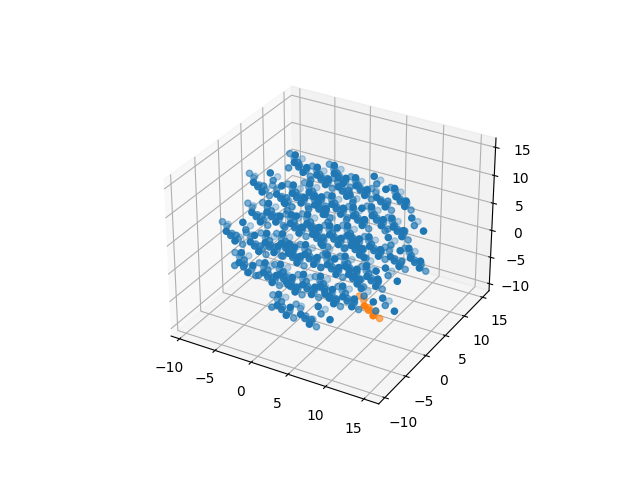

In [6]:
print(fragment_index)
plot_fragments(fragments,1)#,fragment_index)
fragment_index += 1

In [47]:
output_topology = enlarged_topology.to_json()
print(output_topology)

with open("output.json",'w') as f:
    json.dump(output_topology,f,indent=4)
    

{'fragments': [[140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 330, 331, 332, 333, 334, 15, 16, 17, 18, 19, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 650, 651, 652, 653, 654, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 375, 376, 377, 378, 379], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 230, 231, 232, 233, 234, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 305, 306, 307, 308, 309, 565, 566, 567, 568, 569, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 20, 21, 22, 23, 24, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 65, 66, 67, 68, 69, 590, 591, 592, 593, 594, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 705, 706, 707, 708, 709, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 405, 406, 407, 408, 409], [555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 430, 431, 432, 433, 434, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614